In [1]:
import sys
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.cluster.util import cosine_distance
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from konlpy.tag import Mecab
import kss
import pandas as pd
import pickle

In [2]:
class Text_Summarizer():
    def __init__(self):
        
        self.mecab = Mecab(dicpath=r"C:\mecab\mecab-ko-dic")
        #rank높은 문장 갯수
        self.top_n = 3
        
        ##불용어 사전
        stop_words_f ="./stopwords.txt"
        with open(stop_words_f, "r", encoding='utf-8') as f:
             stop_words = f.readlines()
        self.stop_words = [stop_word.strip() for stop_word in stop_words]
        
    #문장 cleaning
    def cleaning(self, sentences):
        for i in range(len(sentences)):
            sentences[i] = re.sub('\《.*\》|\s-\s.*', '', sentences[i])
            sentences[i] = re.sub('\(.*\)|\s-\s.*', '', sentences[i])
            #필드의 태그를 모두 제거
            sentences[i] = re.sub('(<([^>]+)>)', '', sentences[i])
            # 개행문자 제거
            sentences[i] = re.sub('\n', ' ', sentences[i])
            #특수문자 제거
            sentences[i] = re.sub(r'[^\w\s]', '', sentences[i])
        return sentences    
    
    #mecab으로 조사, 전치사 분리
    def mecab_morphs(self, sentences):
        for i, sentence in enumerate(sentences):
            sentences[i] = self.mecab.morphs(sentence)
        return sentences

    #mecab으로 #일반명사 #고유명사 #대명사 #동사 #형용사
    def mecab_pos(self, sentences):
        
        for i, sentence in enumerate(sentences):
            sent_pos = []
            for word in self.mecab.pos(sentence):
                if word[1] in ['NNG', 'NNP','NP','VV','VA' ]:
                    sent_pos.append(word[0])
            sentences[i] = sent_pos
        return sentences
    
    def sentence_similarity(self, sent1, sent2):
        
        #토큰이 비어있으면 제거
        for i in range(len(sent1)):
            if range(len(sent1[i])) == 0:
                sent1.pop(i)
        for i in range(len(sent2)):
            if range(len(sent2[i])) == 0:
                sent2.pop(i)
        #비교할 문장들의 토큰합
        all_words = list(set(sent1 + sent2))
        
        #cosine 유사도를 구할 vector 생성
        vector1 = [0] * len(all_words)
        vector2 = [0] * len(all_words)
        
        # 첫 문장 생성
        for w in sent1:
            if w in self.stop_words:
                continue
            vector1[all_words.index(w)] += 1
        # 두번째 문장 생성
        for w in sent2:
            if w in self.stop_words:
                continue
            vector2[all_words.index(w)] += 1
        
        #유사도 계산
        return 1 - cosine_distance(vector1, vector2)

    def graph_draw(self):
        #각 노드는 각 문장을 의미 엣지의 두께는 연결된 노드들의 코사인 유사도
        size = 10
        size_similarity_matrix = self.similarity_matrix.flatten()*size
        nx.draw(self.G, with_labels=True, node_color='white', width=size_similarity_matrix.tolist())


    def __call__(self, document, morphs=False):
        
        document2sentence = kss.split_sentences(document)
        #self.document = document.split(". ")
        #최종 output으로 나올 문서 백업
        sentences = document2sentence.copy()
        
        c_sentences = self.cleaning(document2sentence)

        if morphs == True:
            morph_c_sentences = self.mecab_morphs(c_sentences)
        else:
            morph_c_sentences = self.mecab_pos(c_sentences)
        
        #유사도행렬 구성
        self.similarity_matrix = np.zeros((len(sentences), len(sentences)))
        for idx1 in range(len(sentences)):
            for idx2 in range(len(sentences)):
                if idx1 == idx2: #같은 문장은 계산하지않습니다.
                    continue 
                self.similarity_matrix[idx1][idx2] = self.sentence_similarity(morph_c_sentences[idx1], morph_c_sentences[idx2])
    
        #유사도행렬을 인접행렬로 취급 무방향 그래프를 그린다.
        self.G = nx.from_numpy_array(self.similarity_matrix)
        #유사도 행렬로 pagerank 알고리즘 적용
        scores = nx.pagerank(self.G)
        #랭크 높은순으로 최종 요약 제공
        ranked_sentence = sorted(((scores[i],s) for i,s in enumerate(sentences)), reverse=True)
        summarize_text = []
        for i in range(self.top_n):
          summarize_text.append("".join(ranked_sentence[i][1]))
    
        return " ".join(summarize_text)

In [3]:
#BERTopic
from bertopic import BERTopic
#Dimension reduction
from umap import UMAP

from sklearn.feature_extraction.text import CountVectorizer
from konlpy.tag import Mecab
mecab = Mecab(dicpath=r"C:\mecab\mecab-ko-dic")

#정해진 형태소에 token길이가 1인 것도 포함
class CustomTokenizer:
    def __init__(self, tagger, stop_words, tags=None):
        self.tagger = tagger
        self.stop_words = stop_words
        self.tags = tags
    def __call__(self, document):
        if tags == None:
            word_tokens = self.tagger.morphs(document)
        else:
            word_tokens = []
            for word in mecab.pos(document):
                if word[1] in self.tags:
                    word_tokens.append(word[0])
                
        result = [word for word in word_tokens \
                  if word not in self.stop_words]
        return result

#불용어 사전
stop_words_f ="./stopwords.txt"
with open(stop_words_f, "r", encoding='utf-8') as f:
    stop_words = f.readlines()
    stop_words = [stop_word.strip() for stop_word in stop_words]

#토큰처리할 형태소
tags = ['NNG', 'NNP','NP','NNB' ]

custom_tokenizer = CustomTokenizer(mecab, stop_words, tags)
vectorizer = CountVectorizer(tokenizer=custom_tokenizer, max_features= 3000)

#학습한 BERTopic 불러오기
model = BERTopic.load("news_documents_topic_model")

In [19]:
#inference
def inference(document, num_of_topics = 2):
    text_summarize = Text_Summarizer()
    summarize = text_summarize(document)
    print(summarize)
    print(text_summarize.graph_draw())
    num_of_topics = 2
    similar_topics, similarity = model.find_topics(document, top_n = num_of_topics)
    return similar_topics
    

# 추론하기

In [25]:
text = str(input())

In [26]:
text

"챗지피티란 호칭 가운데 ‘챗(Chat)’은 ‘대화’를, 지피티(GPT)는 ‘사전 훈련된 생성 변환기(Generative Pre-trained Transformer)’란 뜻이다. 대량의 데이터를 학습해 마치 사람처럼 스스로 생각하고 판단하도록 설계된 초거대 인공지능(Hyperscale AI)을 바탕으로 사용자가 건넨 질문에 대화하듯 답을 ‘생성’해 내놓는 서비스라고 해서 ‘생성 에이아이(AI)’라고도 불린다. 인간이 써둔 콘텐츠를 검색해 결과값만 보여주는 것이 아니라 자신이 ‘생성’했다고 주장하는 당돌함이 이 챗지피티 서비스의 핵심이고, 2023년 전세계가 이 결과값에 열광하고 있는 모습이다. 한국지능정보사회진흥원 에이아이(AI)·미래전략센터(이하 미래전략센터)는 미래세대에선 결국 인공지능(AI)을 얼마나 잘 다루는가가 중요한 경쟁력으로 부각될 것이라는 전망을 담은 보고서를 내놨다. ‘챗지피티는 혁신의 도구가 될 수 있을까'란 제목의 이 보고서를 보면, “앞으로 아이들은 궁금증을 인공지능으로 해소하고 인공지능으로 여가를 즐기는 ‘에이아이(AI) 네이티브’로 성장”한다. 또한 이들 세대는 큰 변화의 물결 속에서 기회와 위기의 사이에 위치해 있다.“구글은 끝났다(Google is done).” 챗지피티 출시 뒤 영국 일간 <인디펜던트>가 쓴 기사 제목이다. <뉴욕타임스>는 구글이 챗지티피와 관련해 비상사태를 선포하고, 래리 페이지와 세르게이 브린 등 창업자에게 도움을 요청했다고 보도했다. 미래전략센터는 보고서에서 “텍스트보다 영상과 이미지에 익숙한 엠제트(MZ) 세대가 궁금한 것을 검색할 때 구글, 네이버 등 포털사이트 대신 유튜브, 틱톡 등 소셜미디어를 찾는 것처럼, 앞으로 ‘챗봇 네이티브’ 세대의 등장으로 전통적인 형태의 검색 엔진은 경쟁력이 잃고 사라질 위기에 처할 수 있다”고 전망했다. 최수연 네이버 대표는 지난 3일 실적발표 콘퍼런스콜에서 “검색엔진 연구의 일환으로 상반기 중 생성 인공지능 서비스 ‘서치지피티(GPT)’를 출시할 것”이라고 밝혔다. 미래전

미래전략센터는 “학생들이 생성 인공지능의 정보 출처를 인지하고 자동화된 인공지능 모델의 사용법과 한계를 배울 수 있도록 디지털 교육이 필요하다”고 강조했다. 학생들의 디지털 기기 이용 수준과 인공지능 교육 여부에 따라서도 양극화가 발생할 수 있다. 챗지피티란 호칭 가운데 ‘챗(Chat)’은 ‘대화’를, 지피티(GPT)는 ‘사전 훈련된 생성 변환기(Generative Pre-trained Transformer)’란 뜻이다.
None


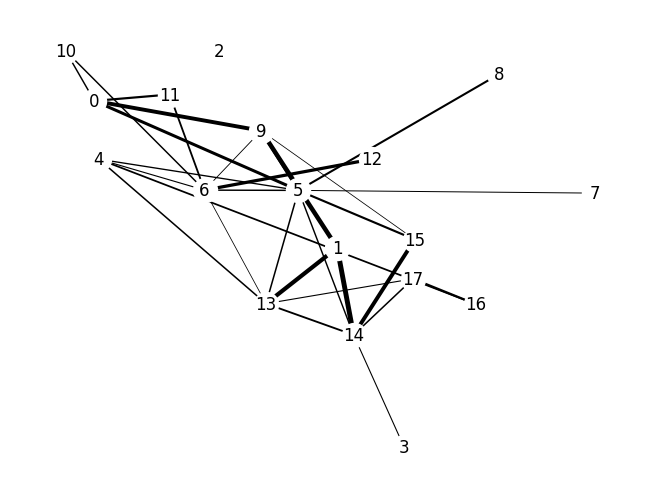

In [27]:
#문서요약
sim_topics = inference(text)
model.visualize_barchart(topics= sim_topics, n_words = 15)

In [34]:
# Visualize intertopic distance
model.visualize_topics()